# Y E A S T

### 'fine replicates' and their consistency 

In [5]:
import pandas as pd
import numpy as np
import scipy.special as sc
import matplotlib.pyplot as plt
import matplotlib as m

plt.rcParams["figure.dpi"] = 300

In [7]:
# basic bayexpress functions

# calculating Bayes factors
def get_BF(N_1, n_1, N_2, n_2):

    return (sc.betaln( u_1 + n_1, u_2 + N_1 - n_1) + sc.betaln( u_1 + n_2, u_2 + N_2 - n_2) - sc.betaln( u_1 + n_1 + n_2, u_2 + N_1 - n_1 + N_2 - n_2)) / np.log(10) 

# ratio of expression 
# calculating log fold change
def get_FC(N_1, n_1, N_2, n_2):
    rate_1 = (u_1 + n_1) / (u_2 + N_1 - n_1)
    rate_2 = (u_1 + n_2) / (u_2 + N_2 - n_2)

    return np.log2(rate_2 / rate_1)

# calculating q (following Laplace's rule of succession)
def get_q(n, N):
    return (n+1)/(N+2)

# setting the priors to flat prios
u_1 = 1
u_2 = 1


# calculating Bayes factors for consistency checks

def get_BF_IC(data):
    # this range is irrelevant if we want to do all 
    k = len(data.columns)

    evidence2 = np.full(len(data), 0)

    # iterating over j until k
    for col in data.columns[1:k]: 
        n_j = data[col]
        # print(n_j, 'n_j')
        N_j = sum(data[col])
        # print(N_j, 'N_j')
        evidence2 = evidence2 + sc.betaln(u_1 + n_j, u_2 + N_j - n_j)

    N = sum(data.iloc[:,1:k].sum(axis=0, numeric_only=True))
    n_i = data.iloc[:,1:k].sum(axis=1, numeric_only=True)

    # print(n_i, 'n_i')
    # print(N, 'N')

    evidence1 = sc.betaln( u_1 + n_i, u_2 + N - n_i)

    return (evidence2 - evidence1) / np.log(10) 


In [8]:
# exploring 'cumulative' BF

def get_cumu_BF(data):
    out_data = pd.DataFrame({})
    for k in range(3,len(data.columns)+1):

        evidence2 = np.full(len(data), 0)

        # iterating over j until k
        for col in data.columns[1:k]: 
            n_j = data[col]
            # print(n_j, 'n_j')
            N_j = sum(data[col])
            # print(N_j, 'N_j')
            evidence2 = evidence2 + sc.betaln(u_1 + n_j, u_2 + N_j - n_j)

        N = sum(data.iloc[:,1:k].sum(axis=0, numeric_only=True))
        n_i = data.iloc[:,1:k].sum(axis=1, numeric_only=True)

        # print(n_i, 'n_i')
        # print(N, 'N')

        evidence1 = sc.betaln( u_1 + n_i, u_2 + N - n_i)
        
        out_data[f'{k-1}'] = (evidence2 - evidence1) / np.log(10) 

    return out_data


### CONSISTENCY TESTS

In [9]:
WT_yeast = pd.read_csv('WT_yeast.csv', index_col=0)
Snf2_yeast = pd.read_csv('Snf2_yeast.csv', index_col=0)

display(WT_yeast)
display(Snf2_yeast)

,genes,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,15S_rRNA,2,12,31,8,21,11,2,3,7,...,0,49,9,4,11,12,1,22,12,4
1,21S_rRNA,20,76,101,99,128,74,36,32,57,...,10,274,49,30,72,58,21,159,107,70
2,HRA1,3,2,2,2,3,5,4,0,4,...,5,3,6,5,2,2,2,5,2,1
3,ICR1,75,123,107,157,98,245,119,120,119,...,85,177,137,118,113,81,142,94,187,106
4,LSR1,60,163,233,163,193,375,194,84,211,...,66,385,232,149,114,81,109,132,243,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7122,tY(GUA)M1,0,0,1,1,1,1,0,0,1,...,0,1,1,0,1,0,0,0,1,0
7123,tY(GUA)M2,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7124,tY(GUA)O,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


,genes,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,15S_rRNA,4,2,5,5,46,5,4,2,40,...,7,15,6,1,85,8,34,3,6,3
1,21S_rRNA,31,18,23,44,356,35,33,13,148,...,64,79,67,13,576,52,234,23,44,24
2,HRA1,5,1,3,1,2,1,4,4,0,...,5,5,0,2,0,1,2,2,0,1
3,ICR1,205,196,211,252,127,275,160,190,146,...,286,155,184,164,202,186,148,183,195,145
4,LSR1,210,103,159,260,298,303,96,132,263,...,250,195,153,57,742,227,227,117,224,136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,2,1,1
7122,tY(GUA)M1,0,0,1,0,2,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
7123,tY(GUA)M2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7124,tY(GUA)O,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [10]:
# calculating 'cumulatative' BF_IC

WT_cumu = get_cumu_BF(WT_yeast)

display(WT_cumu)

Snf2_cumu = get_cumu_BF(Snf2_yeast)


display(Snf2_cumu)

,2,3,4,5,6,7,8,9,10,11,...,33,34,35,36,37,38,39,40,41,42
0,-4.824123,-4.912829,-8.839685,-14.117564,-17.996641,-21.086076,-24.943705,-30.693142,-36.473404,-36.748828,...,-78.392957,-79.236264,-83.873072,-87.899103,-93.755645,-99.564530,-98.737339,-102.165373,-107.111094,-111.028167
1,-0.963656,0.632576,-4.889390,-5.707717,-1.756501,-1.034256,1.474677,-3.694451,-4.328017,30.503034,...,314.603331,332.522436,337.316054,341.359343,335.890120,333.215257,356.876602,375.089399,370.679089,365.965229
2,-5.943931,-12.083265,-18.278537,-24.465218,-30.802653,-36.940374,-42.530537,-48.629171,-54.649860,-60.521649,...,-192.140921,-198.484739,-204.355581,-210.085429,-216.320230,-222.587706,-228.790003,-234.076721,-240.250222,-246.380070
3,-4.823112,-9.807353,-15.238338,-19.905392,-24.625241,-29.785183,-34.360645,-39.709611,-44.590227,-49.889550,...,-155.375929,-160.782614,-166.296698,-171.236715,-175.771447,-179.030847,-184.072077,-188.751188,-193.899154,-199.310861
4,0.108211,10.803119,9.032746,4.700363,1.487643,-3.873543,11.533645,7.137768,1.803757,6.654632,...,249.996802,253.183338,247.773924,242.971550,239.948338,250.582110,269.366427,264.188637,259.247720,257.043307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,-6.286567,-12.763830,-19.421876,-26.124338,-32.363821,-39.044382,-45.782284,-52.528131,-59.264657,-65.422555,...,-215.130801,-222.115884,-229.041179,-235.853189,-242.628019,-249.481368,-256.468048,-263.178684,-270.184691,-277.038617
7122,-6.531056,-12.675472,-19.165382,-25.559965,-32.208462,-38.822300,-45.496440,-51.930123,-58.585525,-65.225674,...,-209.970841,-216.538875,-223.000753,-229.707786,-235.891374,-242.622613,-249.440170,-256.071351,-262.651404,-269.387754
7123,-6.531056,-12.675472,-19.333519,-26.035980,-32.922786,-39.191373,-45.993039,-52.789226,-59.566314,-66.302507,...,-215.904536,-222.907910,-229.847933,-236.670440,-243.454560,-250.319009,-257.321064,-264.038923,-271.060168,-277.923892
7124,-6.531056,-13.174062,-20.012232,-26.815334,-33.841214,-39.875493,-46.740922,-53.587450,-60.405100,-67.173308,...,-217.027288,-224.048953,-230.003826,-236.826334,-243.610453,-250.474902,-257.476958,-264.194816,-271.216061,-277.030310


,2,3,4,5,6,7,8,9,10,11,...,35,36,37,38,39,40,41,42,43,44
0,-6.103991,-12.057457,-18.248233,-0.689254,-4.779452,-10.148008,-14.380417,-8.405656,-13.822875,-19.135557,...,58.990171,53.171198,50.286105,48.540940,67.204146,63.100998,59.969102,58.492922,55.074698,52.273279
1,-5.373082,-11.152096,-15.709169,164.012305,176.098447,175.473667,187.389002,199.129378,194.351127,194.767768,...,804.627349,799.728536,799.019121,811.207678,1011.496083,1014.180313,1037.861715,1054.538366,1059.645076,1068.603540
2,-5.776665,-11.988302,-18.045738,-24.279166,-30.448821,-36.302987,-42.457222,-48.388459,-54.694911,-60.979764,...,-209.316343,-214.850561,-220.739455,-226.997613,-232.939793,-239.278730,-245.600999,-251.971431,-257.999634,-264.347894
3,-4.971297,-9.804811,-14.992280,-19.330740,-24.753763,-29.744215,-34.505353,-38.882697,-44.050455,-49.311961,...,-155.746721,-161.075340,-166.370178,-170.515722,-175.754308,-181.035691,-186.357233,-191.677668,-196.533408,-201.913097
4,-0.576562,-5.754128,-6.633886,15.230201,10.031782,15.283111,17.306187,20.515392,18.416235,13.685228,...,321.437539,316.081994,316.897201,329.751911,485.680806,480.472207,476.587686,482.279438,477.098099,473.797677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,-6.404911,-13.017210,-19.762178,-26.456642,-33.341253,-39.530966,-46.347490,-53.129063,-59.979981,-66.750607,...,-230.114841,-236.079392,-242.999319,-249.784977,-256.694193,-263.577612,-270.417138,-275.356707,-281.477286,-287.490152
7122,-6.672068,-12.950527,-19.695495,-25.231652,-31.904670,-38.586324,-45.341319,-52.078137,-58.880708,-65.618429,...,-222.528536,-228.875641,-235.353807,-242.033736,-248.799687,-255.553666,-262.281139,-269.041926,-275.805506,-282.046301
7123,-6.672068,-13.449795,-20.336202,-27.102349,-34.092758,-40.946441,-47.886024,-54.757106,-61.704721,-67.404270,...,-229.953348,-236.815191,-243.748169,-250.542638,-257.463792,-264.357998,-271.206862,-278.100616,-284.993383,-291.816655
7124,-6.334297,-12.946597,-19.691564,-26.386028,-33.270640,-40.066980,-46.945034,-53.063258,-59.914177,-66.684802,...,-228.743133,-234.775721,-241.682596,-248.459444,-255.356721,-262.229353,-269.059542,-275.932839,-282.805731,-289.612759


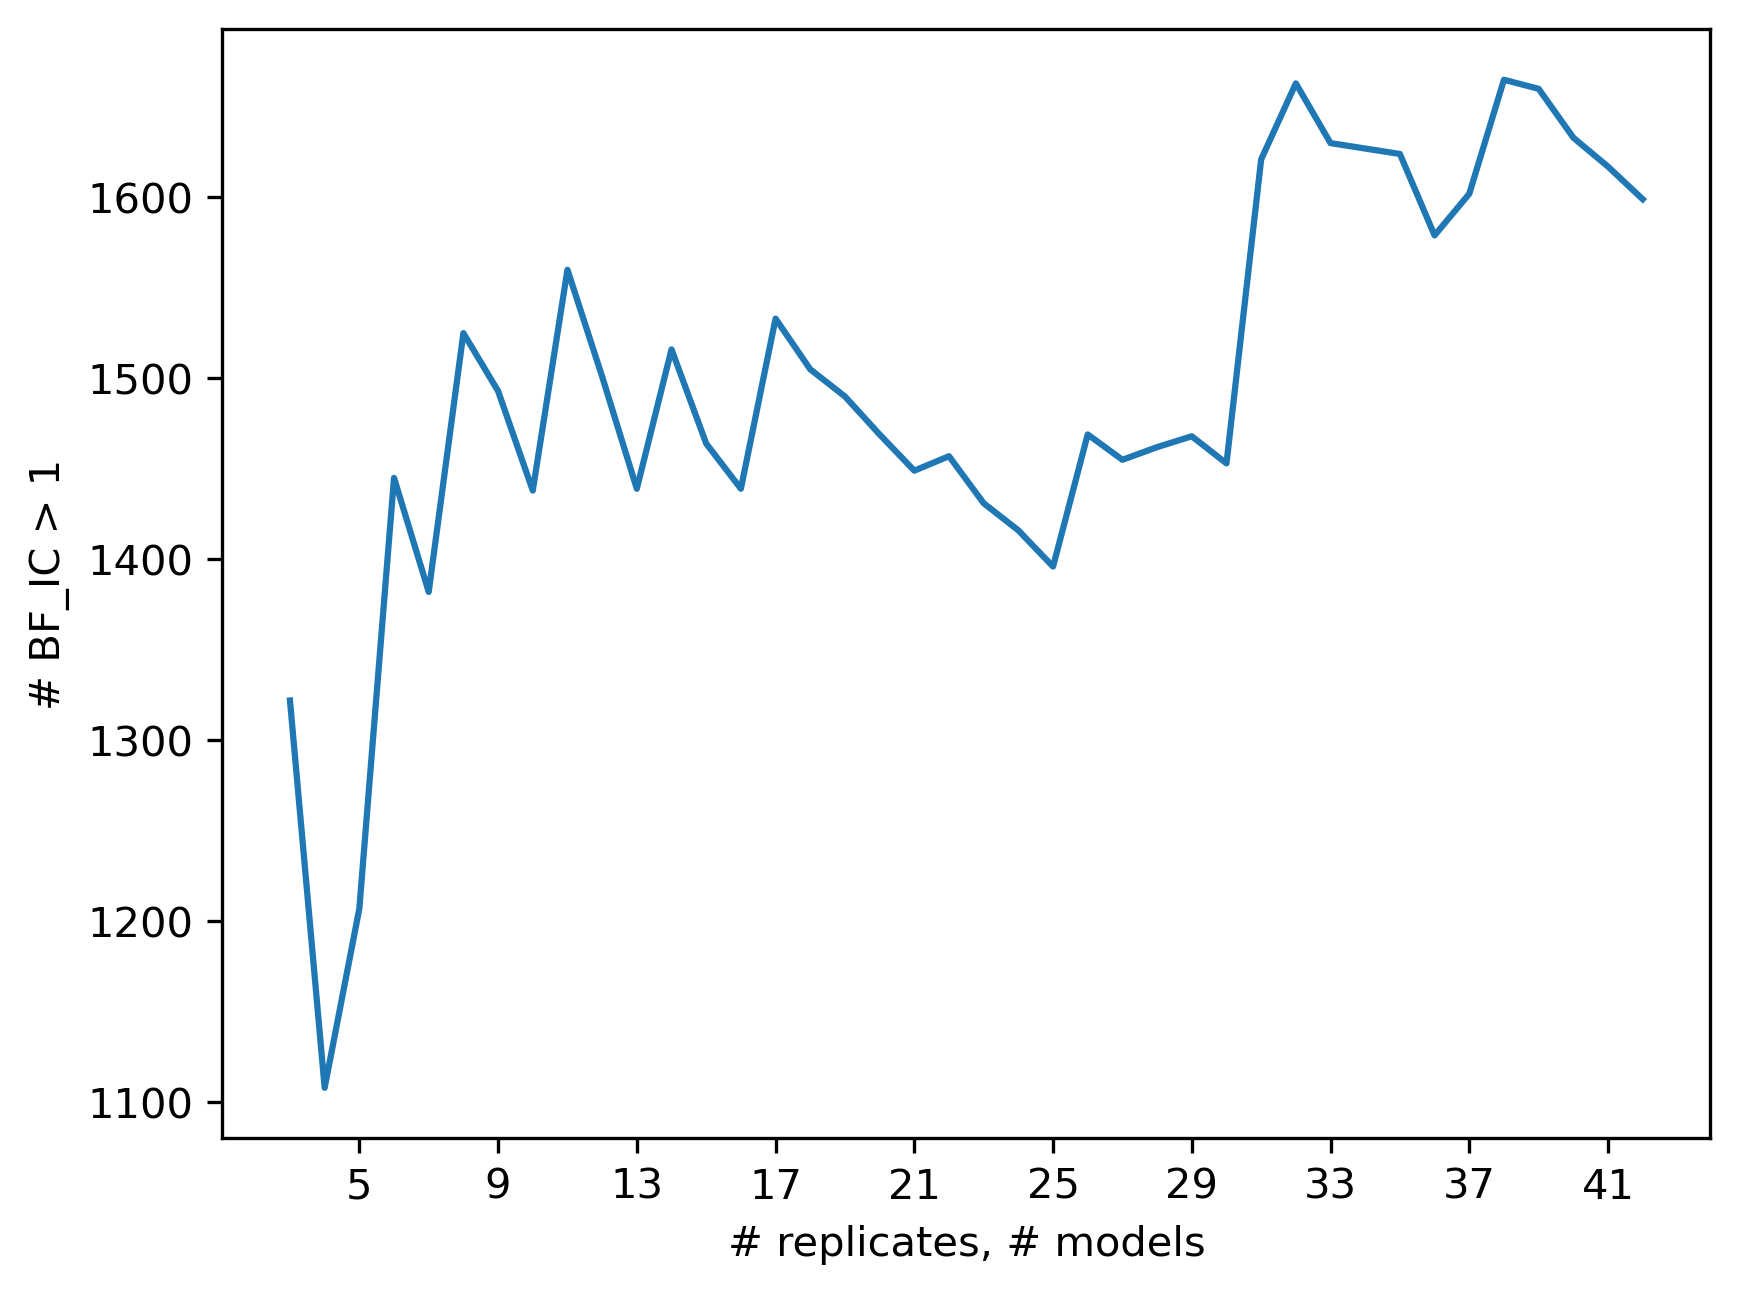

In [11]:
# this is the general idea

# finding the number of genes with BF_IC > 1 while increasing number of reps
series = (WT_cumu.iloc[:,1:] > 1).sum()

series.plot(xlabel='# replicates, # models', ylabel='# BF_IC > 1', xticks=range(2,len(series),4), legend=False)


plt.show()

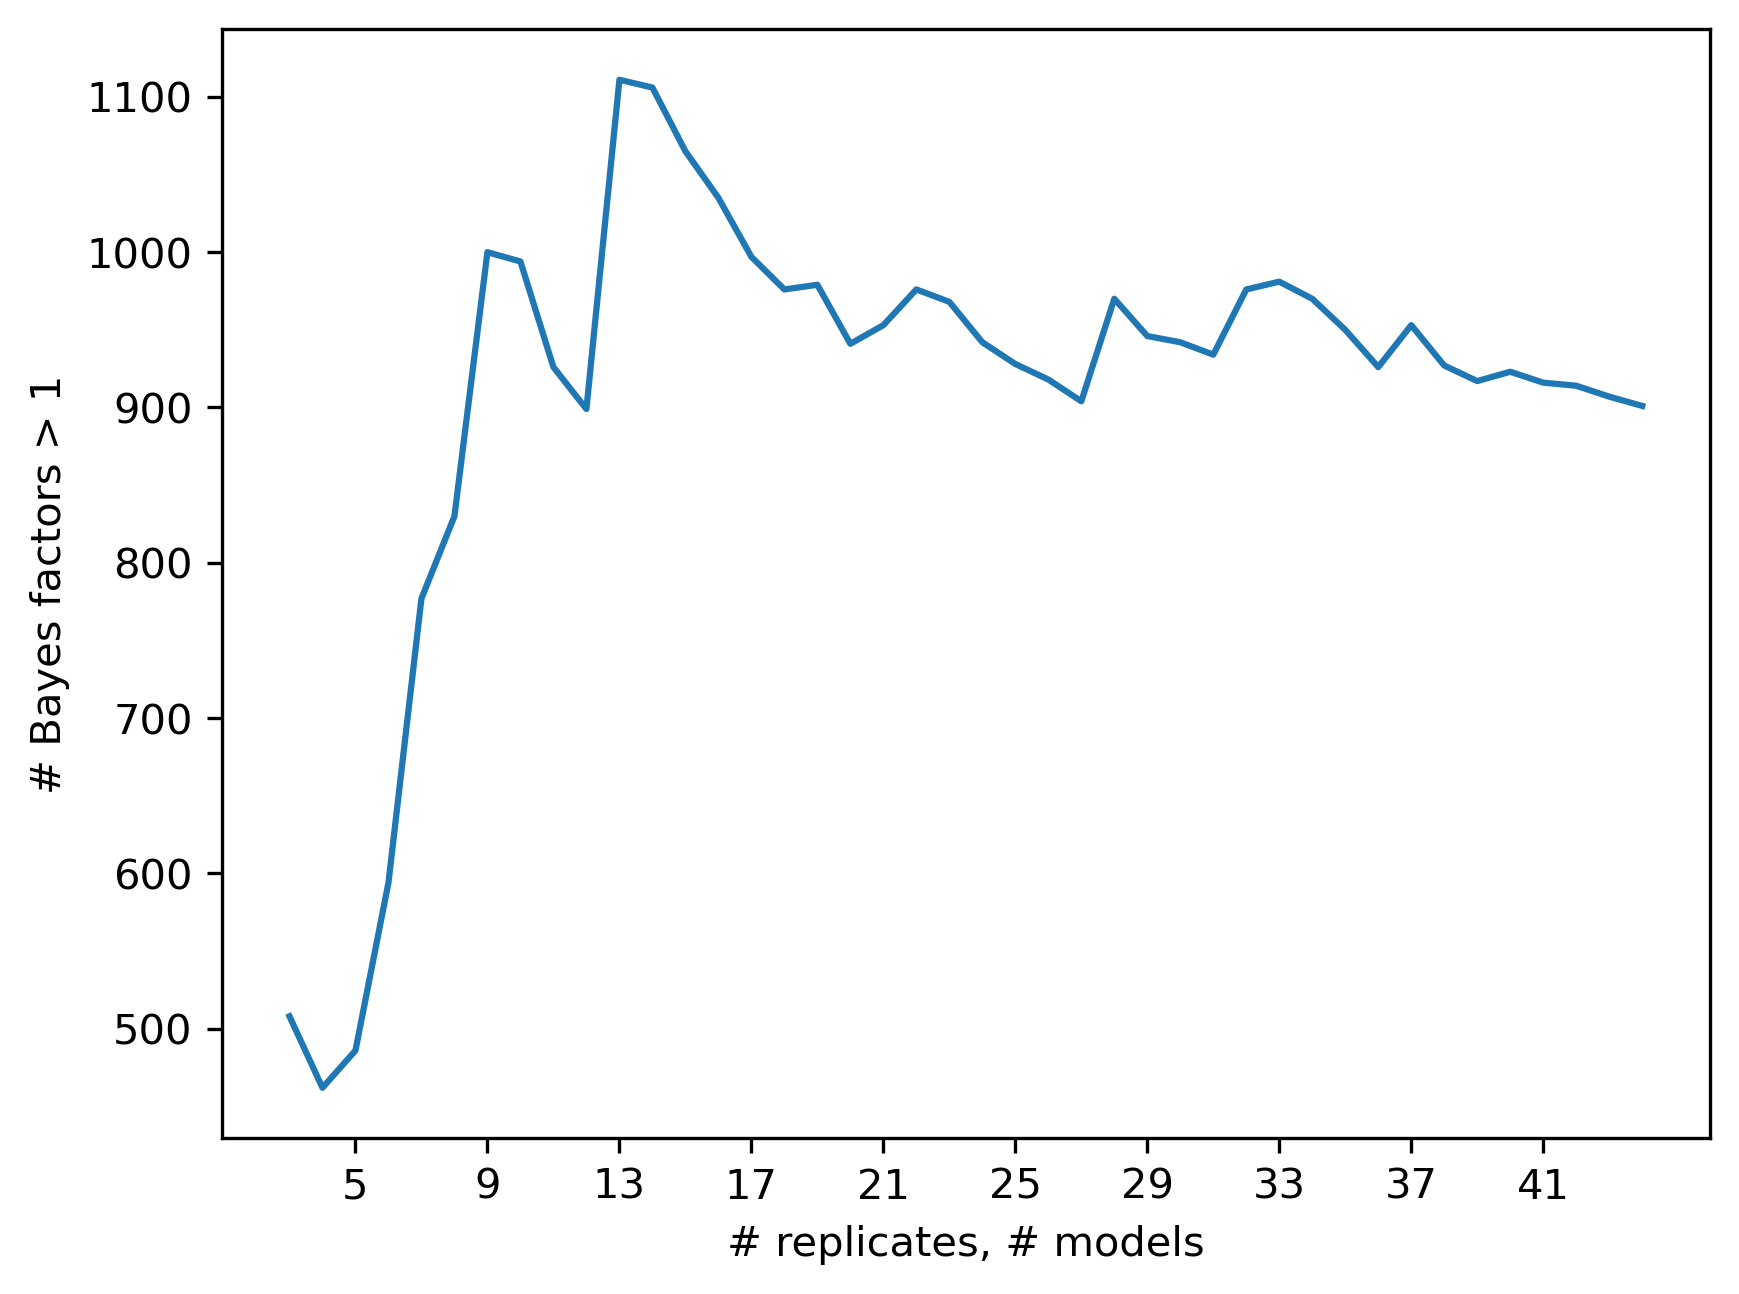

In [12]:
# this is the general idea

# finding the number of genes with nBF > 1 while increasing number of reps
series = (Snf2_cumu.iloc[:,1:] > 1).sum()


series.plot(xlabel='# replicates, # models', ylabel='# Bayes factors > 1', xticks=range(2,len(series),4), legend=False)

plt.show()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2,1691,1188,2654,654,2372,2300,772,819,1551,893,1255,2493,1537,660,1551,1074,1768,1547,1646,434
3,1525,1104,2165,1374,1823,1953,701,515,2073,701,1403,1976,1804,2300,1098,1284,1566,1260,1320,430
4,1475,905,2616,1446,2126,2268,1592,1419,1906,736,1555,1885,1621,2055,1848,1181,1445,1314,1674,385
5,1373,803,2500,1696,1783,2236,1346,1300,1710,1422,1418,1767,1457,1964,2012,1562,1364,1439,1516,1316
6,1253,1074,2373,2040,1790,2140,1425,1319,1640,1527,1303,1762,1692,1902,1815,1631,1574,1235,1606,1211
7,1317,1079,2190,2349,1844,2152,1282,1273,1546,1477,1302,1605,1775,1892,1610,1774,1568,1222,1479,1149
8,1436,1053,2272,2212,1764,1967,1318,1187,1500,1391,1412,1540,1701,1776,1427,1669,1489,1569,1339,1097
9,1374,1288,2115,2315,1621,1887,1299,1133,1424,1532,1358,1443,1618,1653,1400,1617,1452,1513,1410,1693
10,1415,1292,1986,2278,1553,1952,1287,1118,1328,1485,1331,1453,1632,1546,1420,2024,1377,1738,1387,1778
11,1443,1298,1866,2161,1634,2067,1269,1165,1290,1481,1324,1384,1540,1540,1365,1929,1415,1661,1359,1909


<Axes: xlabel='# replicates', ylabel='# BF_IC > 1 of 7126 genes'>

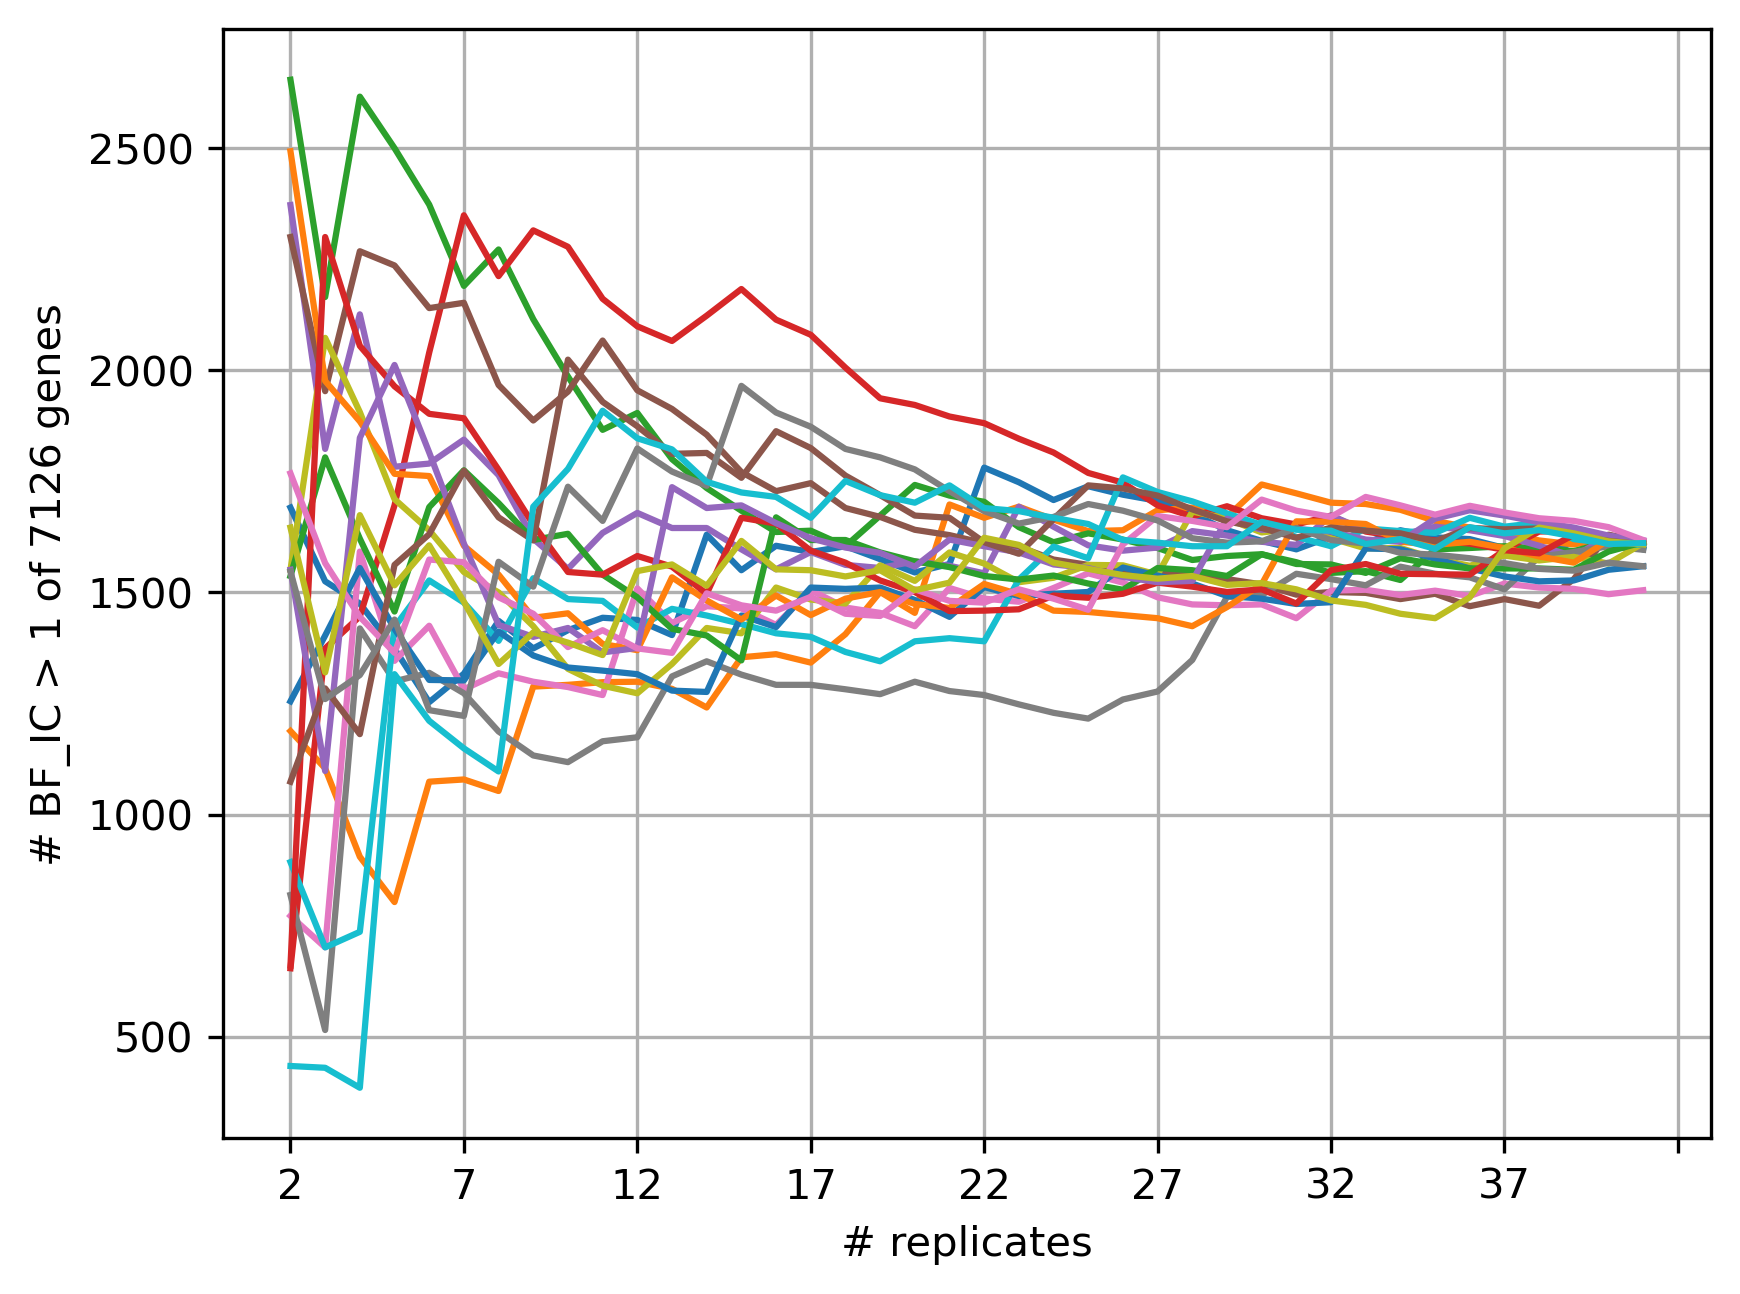

In [13]:
# then bootstrapping this idea
# 20 times for figure

WT_cons_it = pd.DataFrame({})
# let's do this with more iterations
# WT_AOTP = []

for i in range(20):

    col_order = np.array(WT_yeast.columns[1:])
    np.random.shuffle(col_order)
    # print(col_order)

    cumu_BF_IC = get_cumu_BF(WT_yeast[col_order])
    # WT_AOTP.append(WT_yeast.loc[(cumu_BF_IC).iloc[:,-1] > 1].index)

    WT_cons_it[f'{i+1}'] = ((cumu_BF_IC) > 1).sum()

display(WT_cons_it)

display(WT_cons_it.plot(legend=False, grid=True,
                        xlabel='# replicates',
                        ylabel='# BF_IC > 1 of 7126 genes'
                        ))

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
2,1260,737,1548,858,1025,1381,811,349,1965,1218,...,654,355,353,1254,1281,1517,1703,1168,1864,1268
3,1513,1184,1466,707,1188,1101,642,316,1787,2033,...,840,559,1488,951,895,1305,1815,1746,1387,1131
4,1562,1628,1300,1584,1481,1932,773,1557,1506,1948,...,1692,500,1281,1263,1011,1103,1455,1596,1357,1285
5,1424,1669,1409,1539,1335,1940,1147,1794,1448,1755,...,1583,456,1217,1408,1377,1588,1384,1417,1111,1138
6,1583,1647,1955,1430,1503,1984,1200,1827,1284,1611,...,1507,413,1446,1371,1966,1549,1216,1675,1246,1325
7,1528,1690,1778,1765,1498,1855,1145,1767,1277,1624,...,1343,1343,1527,1311,1792,1577,1083,1606,1274,1316
8,1478,1678,1718,1778,1471,1774,1138,1889,1386,1660,...,1278,1573,1657,1281,1750,1582,1056,1712,1354,1295
9,1491,1588,1630,1720,1811,1714,1579,1982,1322,1687,...,1472,1595,1540,1369,1659,1522,1560,1688,1559,1245
10,1471,1605,1666,1639,2181,1704,1510,1916,1433,1701,...,1625,1639,1572,1555,1794,1453,1505,1621,1644,1252
11,1412,1552,1724,1993,2147,1642,1527,1878,1441,1788,...,1641,1650,1513,1561,1709,1501,1413,1548,1656,1680


<Axes: xlabel='# replicates', ylabel='# BF_IC > 1 of 7126 genes'>

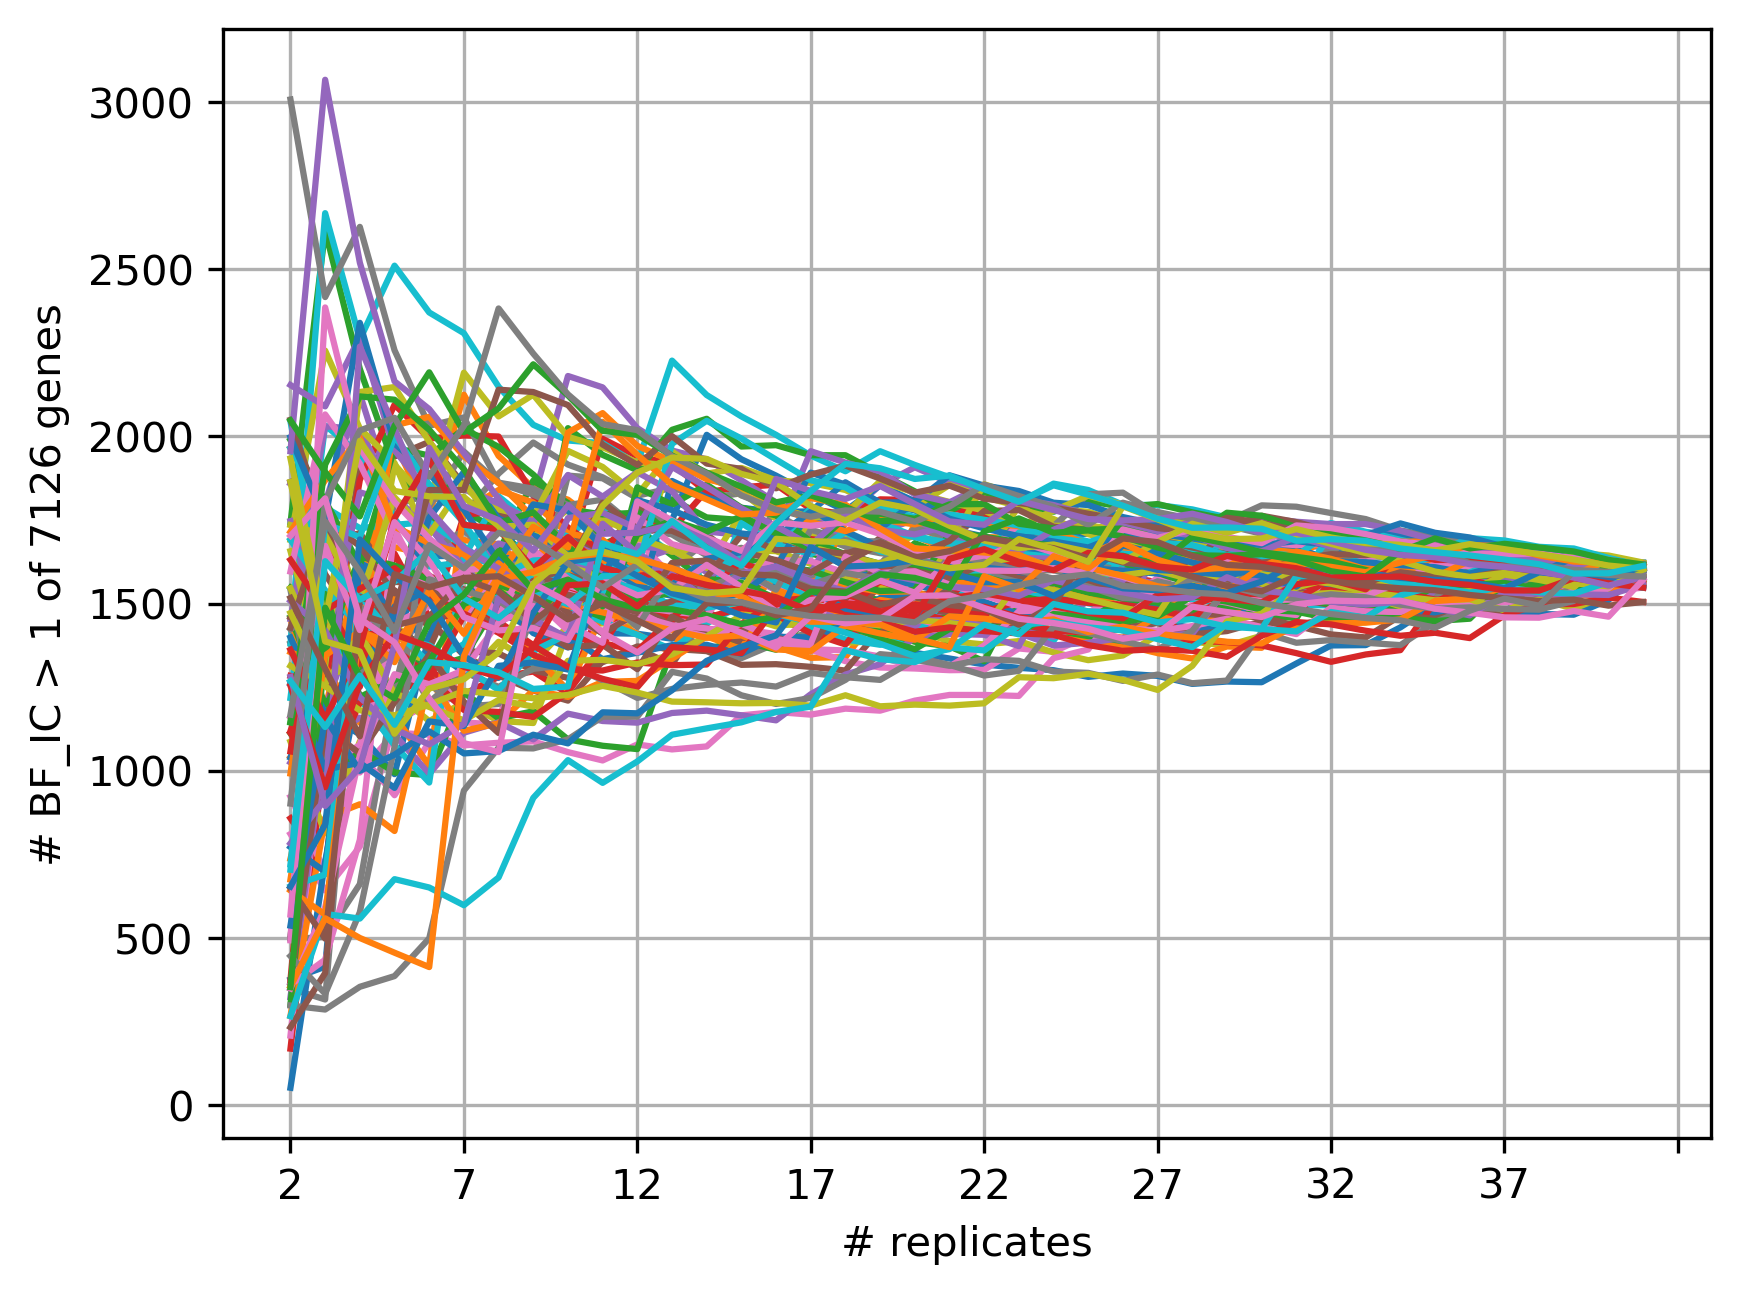

In [14]:
# then bootstrapping this idea
# 100 times for identifying genes

WT_cons_it = pd.DataFrame({})
WT_AOTP = []

for i in range(100):

    col_order = np.array(WT_yeast.columns[1:])
    np.random.shuffle(col_order)
    # print(col_order)

    cumu_BF_IC = get_cumu_BF(WT_yeast[col_order])
    WT_AOTP.append(WT_yeast.loc[(cumu_BF_IC).iloc[:,-1] > 1].index)

    WT_cons_it[f'{i+1}'] = ((cumu_BF_IC) > 1).sum()

display(WT_cons_it)

display(WT_cons_it.plot(legend=False, grid=True,
                        xlabel='# replicates',
                        ylabel='# BF_IC > 1 of 7126 genes'
                        ))

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
2,821,291,382,1231,1931,1641,408,538,663,712,288,208,276,1831,523,290,966,1575,1047,1328
3,596,426,437,1362,1442,1435,560,581,956,1354,914,1043,235,1461,733,385,774,1427,906,1252
4,514,456,423,1329,1273,1032,1393,527,1817,1091,761,817,255,1375,908,525,764,1287,830,1009
5,580,464,387,1250,1200,941,1164,523,1760,978,785,665,307,1351,745,1125,852,1262,807,948
6,547,837,402,1124,1106,804,1073,578,1595,1020,772,764,586,1703,961,1486,743,1261,1005,886
7,629,752,853,1104,1158,977,1095,552,1460,1003,731,755,602,1523,1115,1378,1086,1225,955,874
8,749,835,887,1004,1012,1108,972,573,1346,907,910,721,600,1352,1040,1230,1025,1106,932,820
9,778,894,976,904,1029,1055,924,554,1255,849,850,693,596,1255,1025,1200,968,1151,920,757
10,754,827,932,1095,974,974,883,567,1224,860,901,982,600,1195,1016,1195,933,1108,889,738
11,722,858,1050,996,948,1167,831,557,1183,891,890,958,569,1176,1011,1228,1010,1064,883,759


<Axes: xlabel='# replicates', ylabel='# BF_IC > 1 of 7126 genes'>

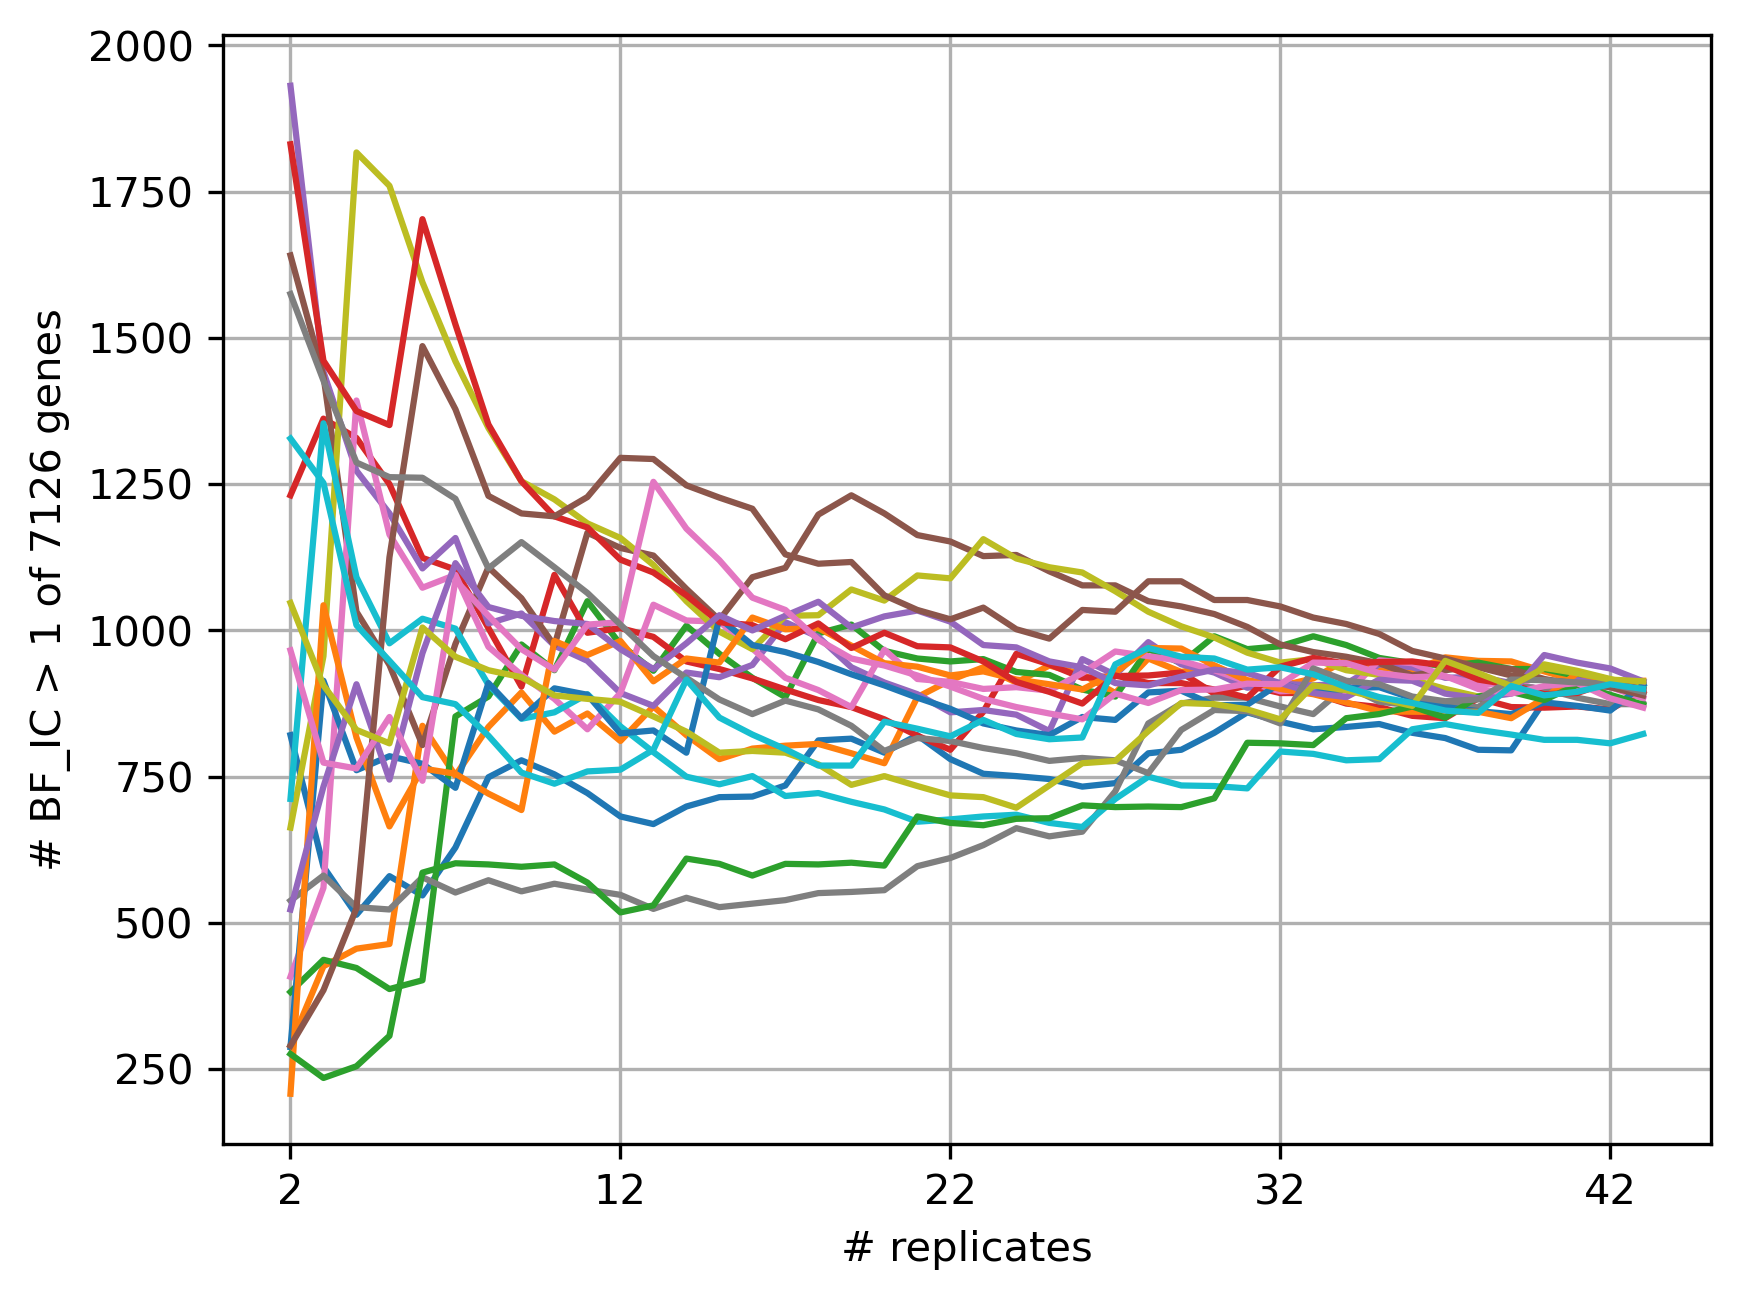

In [15]:
# again, bootstrapping this idea but on the mutant

Snf2_cons_it = pd.DataFrame({})
# Snf2_AOTP = []
# lets do this with more iterations

for i in range(20):

    col_order = np.array(Snf2_yeast.columns[1:])
    np.random.shuffle(col_order)
    # print(col_order)

    cumu_BF_IC = get_cumu_BF(Snf2_yeast[col_order])
    # Snf2_AOTP.append(Snf2_yeast.loc[(cumu_BF_IC).iloc[:,-1] > 1].index)

    Snf2_cons_it[f'{i+1}'] = ((cumu_BF_IC) > 1).sum()

display(Snf2_cons_it)

display(Snf2_cons_it.plot(legend=False, grid=True,
                        xlabel='# replicates',
                        ylabel='# BF_IC > 1 of 7126 genes'
                        ))

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
2,582,329,1904,248,601,844,469,2358,1369,930,...,825,367,213,507,207,180,795,523,269,1305
3,649,638,1428,310,890,513,572,2048,1526,781,...,678,912,679,531,329,294,686,519,886,1570
4,771,610,1053,947,733,622,964,1693,1336,1098,...,661,864,1029,461,398,224,1062,484,1935,1637
5,1064,568,1023,851,672,1063,799,1678,1185,980,...,626,799,973,675,461,847,972,507,1685,1340
6,909,1030,1171,1002,711,1398,925,1664,1198,853,...,616,1479,968,922,445,724,1059,822,1602,1140
7,796,908,1021,965,652,1213,947,1485,1064,807,...,573,1329,825,931,469,719,1008,729,1395,1074
8,766,1297,947,950,655,1116,939,1323,1004,940,...,769,1222,789,914,700,644,1329,772,1254,1040
9,731,1230,906,886,681,1083,890,1288,946,873,...,876,1123,950,824,768,689,1279,739,1167,939
10,724,1196,893,813,639,1007,992,1219,905,846,...,895,1117,1014,760,777,765,1204,713,1087,899
11,707,1245,938,946,622,926,920,1121,888,957,...,829,1048,1048,773,755,717,1134,660,1004,865


<Axes: xlabel='# replicates', ylabel='# BF_IC > 1 of 7126 genes'>

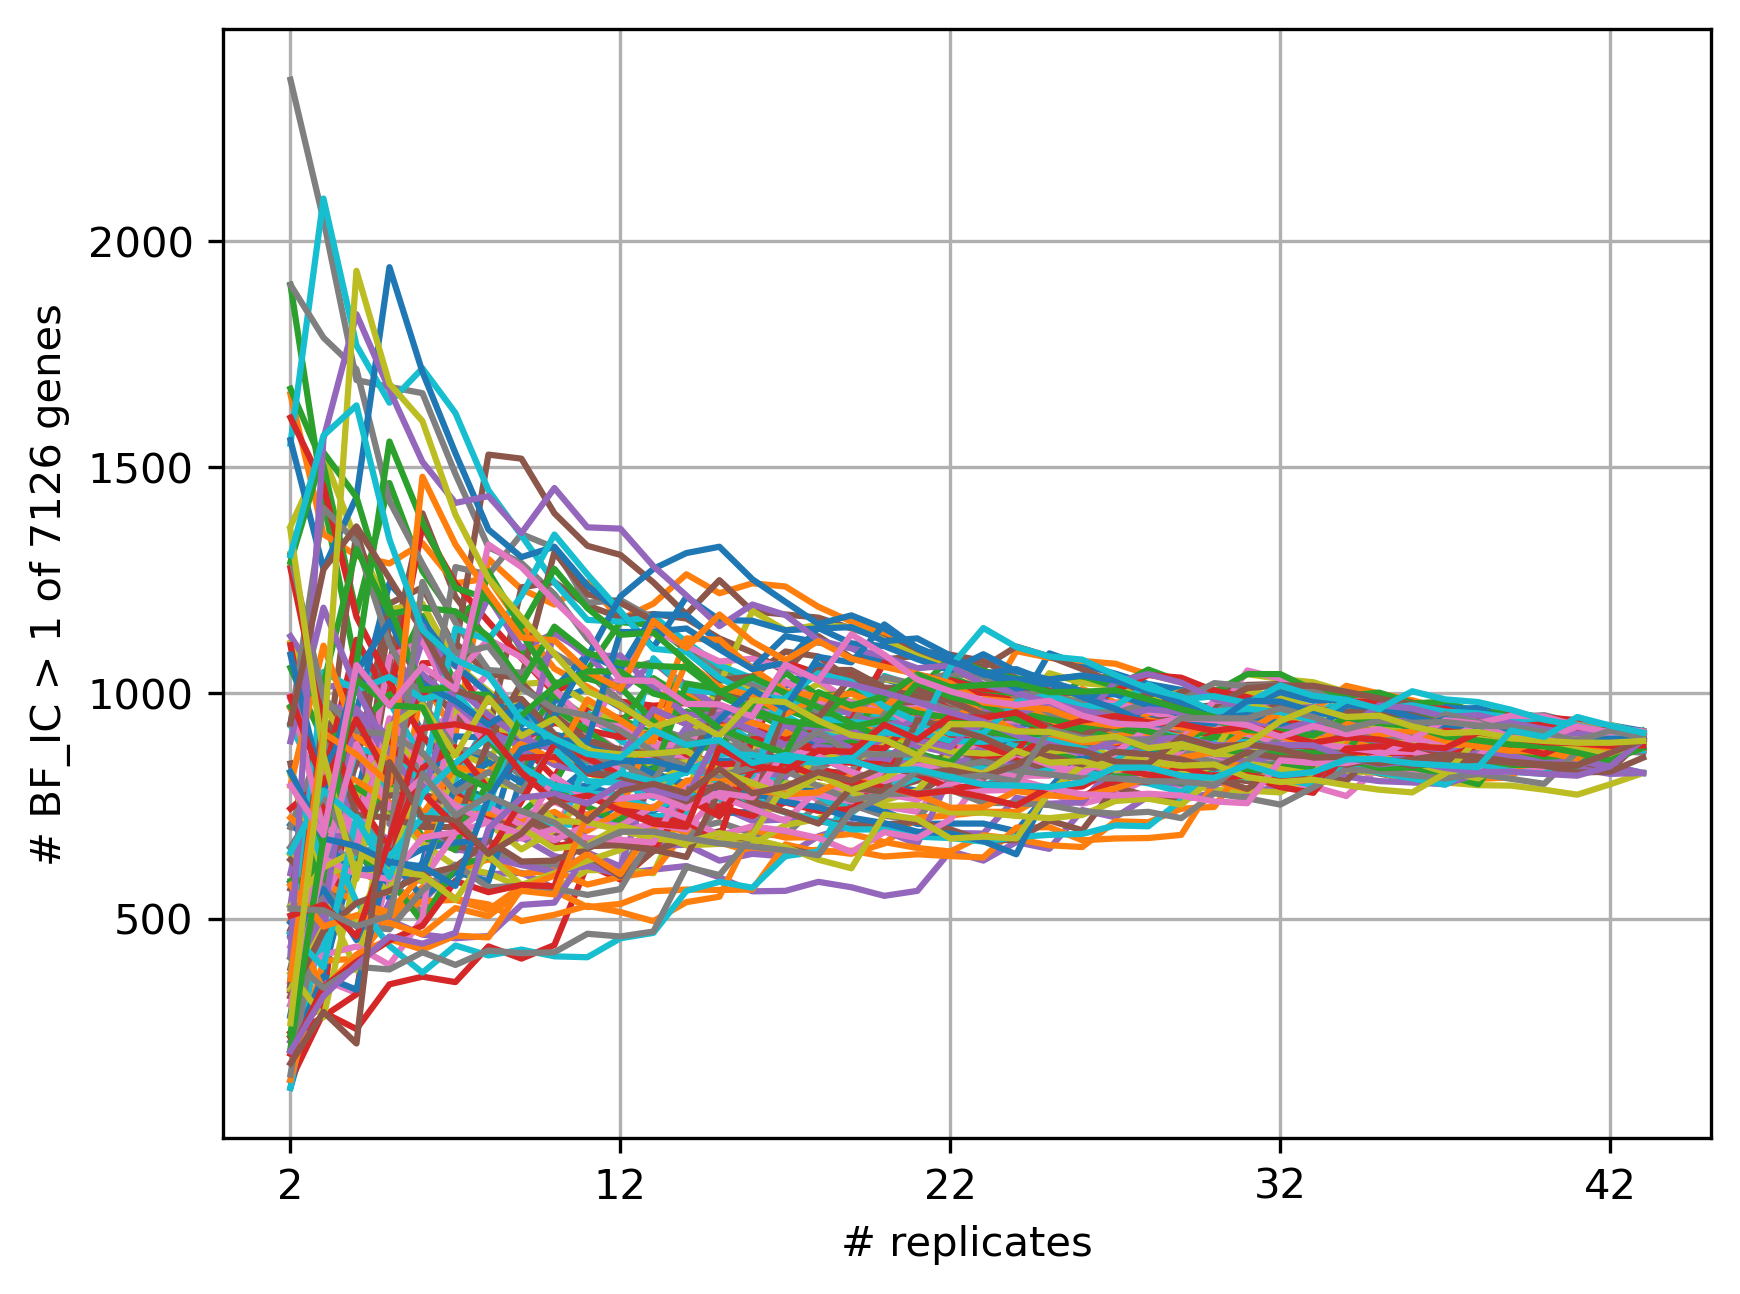

In [16]:
# again, bootstrapping this idea but on the mutant

Snf2_cons_it = pd.DataFrame({})
Snf2_AOTP = []

for i in range(100):

    col_order = np.array(Snf2_yeast.columns[1:])
    np.random.shuffle(col_order)
    # print(col_order)

    cumu_BF_IC = get_cumu_BF(Snf2_yeast[col_order])
    Snf2_AOTP.append(Snf2_yeast.loc[(cumu_BF_IC).iloc[:,-1] > 1].index)

    Snf2_cons_it[f'{i+1}'] = ((cumu_BF_IC) > 1).sum()

display(Snf2_cons_it)

display(Snf2_cons_it.plot(legend=False, grid=True,
                        xlabel='# replicates',
                        ylabel='# BF_IC > 1 of 7126 genes'
                        ))

In [17]:
# Checking for overlaps in Snf2_AOTP

# Convert each inner list to a set
sets = [set(lst) for lst in Snf2_AOTP]

print('# genes with BF_IC > 1 for all replicates throughout the iterations')
for lst in Snf2_AOTP:
    print(len(lst))

# Find the intersection of all sets
Snf2_overlap = set.intersection(*sets)

# Print the Snf2_overlap
print('overlap: ', len(Snf2_overlap))
# print(Snf2_overlap)


# Find the union of all sets
Snf2_union = set.union(*sets)

# Print the union
# print(Snf2_union)
print('union: ', len(Snf2_union))


# genes with BF_IC > 1 for all replicates throughout the iterations
905
913
900
873
901
899
907
872
823
916
906
897
913
912
897
895
873
868
910
914
906
913
914
902
874
912
903
895
897
874
910
910
912
907
895
901
912
912
896
897
910
894
910
898
823
912
913
897
907
902
916
895
897
912
894
910
911
913
911
823
895
914
916
903
823
889
915
911
894
879
900
889
913
906
907
912
911
900
884
912
901
912
899
901
906
857
910
912
889
910
898
879
879
884
897
896
914
902
894
912
overlap:  758
union:  922


In [18]:
# Checking for overlaps in WT_AOTP

# Convert each inner list to a set
sets = [set(lst) for lst in WT_AOTP]

print('# genes with BF_IC > 1 for all replicates throughout the iterations')
for lst in WT_AOTP:
    print(len(lst))

# Find the intersection of all sets
WT_overlap = set.intersection(*sets)

# Print the WT_overlap
print('overlap: ', len(WT_overlap))
# print(WT_overlap)


# Find the union of all sets
WT_union = set.union(*sets)

# Print the union
# print(WT_union)
print('union: ', len(WT_union))


# genes with BF_IC > 1 for all replicates throughout the iterations
1601
1594
1610
1618
1608
1608
1603
1572
1548
1606
1623
1608
1580
1617
1598
1604
1608
1604
1580
1611
1580
1613
1606
1580
1608
1610
1610
1610
1581
1618
1617
1617
1605
1559
1615
1617
1608
1612
1614
1572
1598
1618
1557
1548
1604
1598
1613
1608
1623
1580
1613
1559
1603
1608
1617
1559
1611
1580
1612
1612
1611
1581
1607
1602
1605
1611
1548
1580
1572
1603
1606
1617
1572
1505
1594
1548
1557
1598
1612
1605
1604
1611
1613
1572
1557
1604
1614
1618
1602
1548
1612
1606
1617
1548
1580
1505
1572
1581
1604
1613
overlap:  1426
union:  1633


In [19]:
RALL_bayexpress = pd.read_csv('DGE_results/RALL_bayexpress.csv').iloc[:,1:].rename(columns={'genes': "locus_name"})

RALL_bayexpress

,locus_name,BF,FC
0,15S_rRNA,-3.710645,0.274047
1,21S_rRNA,-1.302642,0.147177
2,HRA1,-5.206545,-0.564787
3,ICR1,76.746125,0.504048
4,LSR1,0.451012,0.120243
...,...,...,...
7121,tY(GUA)J2,-7.312143,0.861839
7122,tY(GUA)M1,-7.406574,0.022303
7123,tY(GUA)M2,-7.727890,0.183767
7124,tY(GUA)O,-7.622253,0.347266


In [20]:
# let's see what those AOTP genes are

display(RALL_bayexpress.iloc[list(WT_union)])
display(RALL_bayexpress.iloc[list(Snf2_union)])

# hmm interesting

,locus_name,BF,FC
1,21S_rRNA,-1.302642,0.147177
4,LSR1,0.451012,0.120243
41,RDN5-1,13.774601,0.316040
46,RDN5-6,15.230943,0.469612
56,RUF5-1,-1.191579,0.080133
...,...,...,...
6731,YPR191W,218.989419,0.279871
6745,YPR204W,814.266672,0.541523
6752,snR17a,7.383833,0.329308
6761,snR30,20.556922,0.159709


,locus_name,BF,FC
0,15S_rRNA,-3.710645,0.274047
1,21S_rRNA,-1.302642,0.147177
4,LSR1,0.451012,0.120243
4100,YLL021W,891.706282,0.521375
4103,YLL024C,9077.546061,-0.490986
...,...,...,...
4063,YKR094C,158.639355,-0.086969
4064,YKR095W,1141.755429,0.533953
4068,YKR098C,843.035626,0.732050
4085,YLL008W,1202.946112,-0.845752


In [21]:
# let's see what AOTP genes have BF > 1

display(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1])
display(RALL_bayexpress.iloc[list(Snf2_union)].loc[RALL_bayexpress.BF > 1])

# hmm interesting

,locus_name,BF,FC
41,RDN5-1,13.774601,0.316040
46,RDN5-6,15.230943,0.469612
58,SCR1,10.530223,0.125605
59,SRG1,365.733360,-0.939803
60,TLC1,777.763124,0.472738
...,...,...,...
6731,YPR191W,218.989419,0.279871
6745,YPR204W,814.266672,0.541523
6752,snR17a,7.383833,0.329308
6761,snR30,20.556922,0.159709


,locus_name,BF,FC
4100,YLL021W,891.706282,0.521375
4103,YLL024C,9077.546061,-0.490986
4105,YLL026W,6986.693811,-0.641283
4118,YLL039C,533.296466,0.257212
4120,YLL041C,3.231386,0.060734
...,...,...,...
4060,YKR091W,757.902699,-0.557891
4063,YKR094C,158.639355,-0.086969
4064,YKR095W,1141.755429,0.533953
4068,YKR098C,843.035626,0.732050


In [22]:
# calculating average <q> for each additional replicate for the plots


def get_avq(data):
    output = pd.DataFrame({'genes': data.genes})
    for k in range(2,len(data.columns)):

        N = sum(data.iloc[:,1:k].sum(axis=0, numeric_only=True))

        n_i = data.iloc[:,1:k].sum(axis=1, numeric_only=True)
        
        output[f'{k-1}'] = (n_i + 1) / (N+2)

    return output


# WT_yeast = get_BF(WT_yeast)

# display(WT_yeast)

# Snf2_yeast = get_BF(Snf2_yeast)

# display(Snf2_yeast)

WT_yeast_avq = get_avq(WT_yeast)

display(WT_yeast_avq)


Snf2_yeast_avq = get_avq(Snf2_yeast)

display(Snf2_yeast_avq)


WT_yeast_avq.to_csv('WT_yeast_avq.csv')
Snf2_yeast_avq.to_csv('Snf2_yeast_avq.csv')

,genes,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,15S_rRNA,5.030082e-07,1.082671e-06,2.266838e-06,1.757651e-06,1.936241e-06,1.611843e-06,1.414441e-06,1.262933e-06,1.211224e-06,...,1.904640e-06,1.853748e-06,1.946728e-06,1.911901e-06,1.879292e-06,1.874652e-06,1.864698e-06,1.802844e-06,1.838121e-06,1.808986e-06
1,21S_rRNA,3.521057e-06,7.001270e-06,9.757261e-06,9.667083e-06,1.097203e-05,9.352440e-06,8.599160e-06,7.869044e-06,7.712282e-06,...,1.143895e-05,1.116937e-05,1.165616e-05,1.143130e-05,1.125617e-05,1.124791e-05,1.114460e-05,1.082007e-05,1.111147e-05,1.103367e-05
2,HRA1,6.706775e-07,4.330683e-07,3.942327e-07,3.254910e-07,3.356151e-07,3.373626e-07,3.536103e-07,3.053245e-07,3.213451e-07,...,3.409082e-07,3.498319e-07,3.457776e-07,3.543033e-07,3.621552e-07,3.608785e-07,3.579971e-07,3.515545e-07,3.605317e-07,3.538079e-07
3,ICR1,1.274287e-05,1.436343e-05,1.507940e-05,1.507023e-05,1.448308e-05,1.510635e-05,1.486771e-05,1.450291e-05,1.438637e-05,...,1.402170e-05,1.395360e-05,1.399016e-05,1.398161e-05,1.403270e-05,1.409661e-05,1.399302e-05,1.393298e-05,1.398095e-05,1.403248e-05
4,LSR1,1.022783e-05,1.616788e-05,2.252055e-05,2.018044e-05,2.098885e-05,2.226593e-05,2.221316e-05,2.034571e-05,2.072676e-05,...,2.320770e-05,2.282563e-05,2.321551e-05,2.321690e-05,2.314857e-05,2.302277e-05,2.269390e-05,2.223207e-05,2.225545e-05,2.218147e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,1.676694e-07,1.443561e-07,9.855819e-08,6.509820e-08,5.163308e-08,7.496946e-08,6.429279e-08,5.551354e-08,4.943770e-08,...,1.852762e-08,1.803257e-08,1.728888e-08,1.671242e-08,1.631330e-08,1.596807e-08,1.556509e-08,1.502370e-08,1.477589e-08,1.426645e-08
7122,tY(GUA)M1,1.676694e-07,7.217804e-08,9.855819e-08,9.764730e-08,1.032662e-07,9.371182e-08,8.036599e-08,6.939192e-08,7.415655e-08,...,4.817182e-08,4.688468e-08,4.840887e-08,5.013727e-08,4.893989e-08,5.109783e-08,4.980829e-08,4.807583e-08,4.728285e-08,4.850592e-08
7123,tY(GUA)M2,1.676694e-07,7.217804e-08,9.855819e-08,6.509820e-08,5.163308e-08,3.748473e-08,4.821959e-08,4.163515e-08,3.707828e-08,...,1.482210e-08,1.442606e-08,1.383111e-08,1.336994e-08,1.305064e-08,1.277446e-08,1.245207e-08,1.201896e-08,1.182071e-08,1.141316e-08
7124,tY(GUA)O,1.676694e-07,7.217804e-08,4.927909e-08,3.254910e-08,2.581654e-08,1.874236e-08,3.214639e-08,2.775677e-08,2.471885e-08,...,1.111657e-08,1.081954e-08,1.037333e-08,1.336994e-08,1.305064e-08,1.277446e-08,1.245207e-08,1.201896e-08,1.182071e-08,1.141316e-08


,genes,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
0,15S_rRNA,4.888009e-07,3.699162e-07,4.332702e-07,4.431870e-07,1.392500e-06,1.178058e-06,1.093068e-06,9.750276e-07,1.354988e-06,...,2.247482e-06,2.162239e-06,2.153404e-06,2.107489e-06,2.068077e-06,2.252873e-06,2.219721e-06,2.264491e-06,2.219710e-06,2.184992e-06
1,21S_rRNA,3.128326e-06,2.642259e-06,2.635727e-06,3.050169e-06,1.045480e-05,8.800790e-06,8.213191e-06,7.299531e-06,8.343876e-06,...,1.195357e-05,1.158432e-05,1.153281e-05,1.139055e-05,1.119966e-05,1.252824e-05,1.236465e-05,1.273472e-05,1.249908e-05,1.232996e-05
2,HRA1,5.865611e-07,3.699162e-07,3.610585e-07,2.867680e-07,2.873412e-07,2.425414e-07,2.732670e-07,2.898731e-07,2.614890e-07,...,2.475201e-07,2.514231e-07,2.603689e-07,2.526609e-07,2.534122e-07,2.465408e-07,2.432571e-07,2.434937e-07,2.431111e-07,2.376114e-07
3,ICR1,2.013860e-05,2.124376e-05,2.213289e-05,2.255039e-05,2.192635e-05,2.195000e-05,2.166400e-05,2.130567e-05,2.095478e-05,...,1.977850e-05,1.973357e-05,1.970839e-05,1.967188e-05,1.975450e-05,1.979128e-05,1.981993e-05,1.979874e-05,1.982148e-05,1.987671e-05
4,LSR1,2.062740e-05,1.659338e-05,1.707807e-05,1.910918e-05,2.278837e-05,2.311074e-05,2.170954e-05,2.058099e-05,2.169170e-05,...,2.351111e-05,2.317493e-05,2.318508e-05,2.295350e-05,2.265855e-05,2.414683e-05,2.418197e-05,2.428173e-05,2.402572e-05,2.406074e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,tY(GUA)J2,1.955204e-07,1.056903e-07,7.221170e-08,5.213964e-08,4.420634e-08,3.464878e-08,4.554450e-08,3.952815e-08,3.565759e-08,...,1.320107e-08,1.571395e-08,1.837898e-08,1.783489e-08,1.747671e-08,1.700282e-08,1.658571e-08,1.623291e-08,2.114009e-08,2.324459e-08
7122,tY(GUA)M1,9.776019e-08,5.284517e-08,7.221170e-08,5.213964e-08,8.841268e-08,6.929756e-08,6.072600e-08,5.270420e-08,4.754345e-08,...,4.950401e-08,5.028463e-08,5.207378e-08,5.350466e-08,5.243012e-08,5.100845e-08,4.975714e-08,4.869873e-08,4.756521e-08,4.648918e-08
7123,tY(GUA)M2,9.776019e-08,5.284517e-08,3.610585e-08,2.606982e-08,2.210317e-08,1.732439e-08,1.518150e-08,1.317605e-08,1.188586e-08,...,1.650134e-08,1.571395e-08,1.531582e-08,1.486241e-08,1.456392e-08,1.416901e-08,1.382143e-08,1.352743e-08,1.321256e-08,1.291366e-08
7124,tY(GUA)O,9.776019e-08,1.056903e-07,7.221170e-08,5.213964e-08,4.420634e-08,3.464878e-08,3.036300e-08,2.635210e-08,3.565759e-08,...,1.980160e-08,1.885673e-08,2.144214e-08,2.080737e-08,2.038949e-08,1.983662e-08,1.935000e-08,1.893840e-08,1.849758e-08,1.807913e-08


In [23]:
RALL_bayexpress['BF_IC_WT'] = get_BF_IC(WT_yeast.iloc[:,1:])
RALL_bayexpress['AOTP_WT'] = RALL_bayexpress.index.isin(WT_union)

RALL_bayexpress['BF_IC_Snf2'] = get_BF_IC(Snf2_yeast.iloc[:,1:])
RALL_bayexpress['AOTP_Snf2'] = RALL_bayexpress.index.isin(Snf2_union)

display(RALL_bayexpress)
RALL_bayexpress.to_csv('RALL_bayexpress.csv')

,locus_name,BF,FC,BF_IC_WT,AOTP_WT,BF_IC_Snf2,AOTP_Snf2
0,15S_rRNA,-3.710645,0.274047,-107.138056,False,53.627445,True
1,21S_rRNA,-1.302642,0.147177,362.115507,True,1052.203968,True
2,HRA1,-5.206545,-0.564787,-240.338654,False,-258.581365,False
3,ICR1,76.746125,0.504048,-194.077441,False,-196.467262,False
4,LSR1,0.451012,0.120243,251.787125,True,478.066414,True
...,...,...,...,...,...,...,...
7121,tY(GUA)J2,-7.312143,0.861839,-270.299503,False,-281.214963,False
7122,tY(GUA)M1,-7.406574,0.022303,-262.736078,False,-275.253246,False
7123,tY(GUA)M2,-7.727890,0.183767,-271.177492,False,-284.863866,False
7124,tY(GUA)O,-7.622253,0.347266,-270.291196,False,-282.682788,False


# How many genes would be marked as not consistent?

In [24]:
display((RALL_bayexpress.BF_IC_WT > 1).describe())

display((RALL_bayexpress.BF_IC_Snf2 > 1).describe())

display(((RALL_bayexpress.BF_IC_WT > 1) & (RALL_bayexpress.BF_IC_Snf2 > 1)).describe())

display(((RALL_bayexpress.BF_IC_WT > 1) | (RALL_bayexpress.BF_IC_Snf2 > 1)).describe())



count      7126
unique        2
top       False
freq       5524
Name: BF_IC_WT, dtype: object

count      7126
unique        2
top       False
freq       6223
Name: BF_IC_Snf2, dtype: object

count      7126
unique        2
top       False
freq       6359
dtype: object

count      7126
unique        2
top       False
freq       5388
dtype: object

In [25]:
WT_yeast_q = pd.DataFrame({})

for col in WT_yeast.columns[1:43]:

    WT_yeast_q[col+'_q'] = (WT_yeast[col]+1) / (sum(WT_yeast[col])+2)

WT_yeast_q.to_csv('WT_yeast_q.csv')

WT_yeast_q

,12_q,21_q,34_q,27_q,14_q,40_q,29_q,4_q,25_q,13_q,...,22_q,1_q,19_q,3_q,5_q,24_q,41_q,15_q,39_q,11_q
0,3.652909e-07,2.093998e-06,4.192114e-06,5.808502e-07,1.353193e-06,4.120753e-06,1.578264e-06,8.628760e-07,6.128721e-07,1.651220e-06,...,7.542872e-07,5.030082e-07,2.573225e-06,4.970523e-06,2.745867e-06,1.042284e-06,1.075839e-06,5.250010e-07,1.727728e-07,4.120217e-06
1,1.461164e-06,1.439624e-05,2.305663e-05,4.065951e-06,7.910972e-06,2.866611e-05,1.167915e-05,9.587511e-06,3.922381e-06,4.513335e-06,...,5.908583e-06,3.521057e-06,9.649594e-06,1.584354e-05,1.610077e-05,5.732564e-06,8.937736e-06,2.756255e-06,1.900501e-06,2.869437e-05
2,8.523455e-07,6.543744e-07,3.353691e-07,9.293603e-07,5.204587e-07,1.074979e-06,6.313054e-07,2.876253e-07,6.128721e-07,3.302440e-07,...,7.542872e-07,6.706775e-07,4.288709e-07,4.659866e-07,4.992486e-07,2.084569e-07,2.482704e-07,1.312503e-07,2.591592e-07,1.471506e-07
3,1.205460e-05,1.518149e-05,1.492393e-05,1.556678e-05,1.634240e-05,1.702050e-05,1.188959e-05,1.514827e-05,1.287031e-05,1.398033e-05,...,1.470860e-05,1.274287e-05,1.275891e-05,1.677552e-05,1.235640e-05,1.396661e-05,1.555828e-05,1.509378e-05,1.235325e-05,1.353786e-05
4,1.692515e-05,2.970860e-05,3.236312e-05,3.090123e-05,1.374011e-05,2.382870e-05,2.788266e-05,1.572352e-05,1.887646e-05,2.201627e-05,...,1.760003e-05,1.022783e-05,1.254447e-05,3.634695e-05,2.421356e-05,2.105414e-05,2.019266e-05,1.312503e-05,9.502503e-06,9.711939e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,1.217636e-07,1.308749e-07,8.384228e-08,1.161700e-07,1.040917e-07,1.791632e-07,1.052176e-07,9.587511e-08,1.225744e-07,1.100813e-07,...,1.257145e-07,1.676694e-07,1.072177e-07,1.553289e-07,1.248121e-07,1.042284e-07,8.275681e-08,1.312503e-07,8.638639e-08,2.943012e-07
7122,1.217636e-07,2.617497e-07,1.676846e-07,2.323401e-07,1.040917e-07,1.791632e-07,1.052176e-07,1.917502e-07,1.225744e-07,1.100813e-07,...,2.514291e-07,1.676694e-07,1.072177e-07,3.106577e-07,2.496243e-07,2.084569e-07,1.655136e-07,1.312503e-07,8.638639e-08,1.471506e-07
7123,1.217636e-07,1.308749e-07,8.384228e-08,2.323401e-07,1.040917e-07,1.791632e-07,1.052176e-07,9.587511e-08,1.225744e-07,1.100813e-07,...,1.257145e-07,1.676694e-07,1.072177e-07,3.106577e-07,1.248121e-07,1.042284e-07,8.275681e-08,1.312503e-07,8.638639e-08,1.471506e-07
7124,1.217636e-07,1.308749e-07,8.384228e-08,1.161700e-07,1.040917e-07,1.791632e-07,1.052176e-07,9.587511e-08,1.225744e-07,1.100813e-07,...,2.514291e-07,1.676694e-07,1.072177e-07,1.553289e-07,1.248121e-07,1.042284e-07,8.275681e-08,1.312503e-07,8.638639e-08,1.471506e-07


In [26]:
Snf2_yeast_q = pd.DataFrame({})

for col in Snf2_yeast.columns[1:43]:

    Snf2_yeast_q[col+'_q'] = (Snf2_yeast[col]+1) / (sum(Snf2_yeast[col])+2)

Snf2_yeast_q.to_csv('Snf2_yeast_q.csv')

Snf2_yeast_q

,29_q,7_q,12_q,32_q,9_q,24_q,38_q,35_q,42_q,3_q,...,11_q,10_q,37_q,5_q,17_q,4_q,25_q,13_q,16_q,28_q
0,4.247007e-07,6.136811e-07,2.240068e-05,4.463240e-07,4.976768e-06,1.205007e-06,2.900728e-07,5.269065e-07,4.541140e-07,6.839056e-07,...,6.755117e-07,8.074703e-07,7.028538e-07,6.827575e-06,1.691104e-06,5.627362e-07,1.822563e-06,9.497976e-07,2.273210e-06,7.889508e-07
1,3.079080e-06,4.173032e-06,8.024281e-05,3.459011e-06,1.808630e-05,7.832543e-06,2.030510e-06,4.281115e-06,2.724684e-06,2.735623e-06,...,3.242456e-06,6.560696e-06,6.827723e-06,5.186051e-05,8.314594e-06,4.220521e-06,2.512533e-05,4.748988e-06,9.930340e-06,6.048623e-06
2,5.308759e-07,6.136811e-07,2.103350e-07,3.347430e-07,1.213846e-07,6.025033e-07,4.351093e-07,3.951799e-07,3.405855e-07,4.559371e-07,...,4.053070e-07,4.037352e-07,1.004077e-07,4.358026e-07,2.818506e-07,1.875787e-07,1.301831e-07,2.374494e-07,4.785706e-07,6.574590e-07
3,2.325236e-05,1.976053e-05,2.187484e-05,1.305498e-05,1.784353e-05,1.491196e-05,2.393101e-05,1.890277e-05,2.088925e-05,2.416467e-05,...,2.202168e-05,1.937929e-05,1.857542e-05,1.859425e-05,1.860214e-05,2.372871e-05,1.978783e-05,1.733381e-05,2.141604e-05,1.354366e-05
4,1.369660e-05,1.190541e-05,9.423009e-05,9.707547e-06,3.204553e-05,1.551446e-05,8.412112e-06,1.653169e-05,1.339636e-05,1.823748e-05,...,2.418332e-05,1.594754e-05,1.546278e-05,4.343500e-05,1.719289e-05,2.447902e-05,2.603662e-05,7.242207e-06,2.141604e-05,1.078233e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121,1.061752e-07,2.454724e-07,1.051675e-07,1.115810e-07,1.213846e-07,1.506258e-07,1.450364e-07,1.317266e-07,3.405855e-07,1.139843e-07,...,1.351023e-07,1.009338e-07,1.004077e-07,1.452675e-07,1.409253e-07,9.378936e-08,1.301831e-07,1.187247e-07,1.196427e-07,1.314918e-07
7122,1.061752e-07,1.227362e-07,1.051675e-07,1.115810e-07,1.213846e-07,1.506258e-07,1.450364e-07,1.317266e-07,1.135285e-07,2.279685e-07,...,1.351023e-07,1.009338e-07,2.008154e-07,4.358026e-07,1.409253e-07,9.378936e-08,1.301831e-07,1.187247e-07,1.196427e-07,2.629836e-07
7123,2.123504e-07,1.227362e-07,1.051675e-07,1.115810e-07,1.213846e-07,1.506258e-07,1.450364e-07,6.586331e-08,1.135285e-07,1.139843e-07,...,2.702047e-07,1.009338e-07,1.004077e-07,1.452675e-07,1.409253e-07,9.378936e-08,1.301831e-07,1.187247e-07,1.196427e-07,1.314918e-07
7124,1.061752e-07,1.227362e-07,1.051675e-07,1.115810e-07,2.427692e-07,1.506258e-07,1.450364e-07,6.586331e-08,1.135285e-07,1.139843e-07,...,1.351023e-07,1.009338e-07,1.004077e-07,1.452675e-07,1.409253e-07,9.378936e-08,1.301831e-07,1.187247e-07,1.196427e-07,1.314918e-07


In [27]:
RALL_bayexpress

,locus_name,BF,FC,BF_IC_WT,AOTP_WT,BF_IC_Snf2,AOTP_Snf2
0,15S_rRNA,-3.710645,0.274047,-107.138056,False,53.627445,True
1,21S_rRNA,-1.302642,0.147177,362.115507,True,1052.203968,True
2,HRA1,-5.206545,-0.564787,-240.338654,False,-258.581365,False
3,ICR1,76.746125,0.504048,-194.077441,False,-196.467262,False
4,LSR1,0.451012,0.120243,251.787125,True,478.066414,True
...,...,...,...,...,...,...,...
7121,tY(GUA)J2,-7.312143,0.861839,-270.299503,False,-281.214963,False
7122,tY(GUA)M1,-7.406574,0.022303,-262.736078,False,-275.253246,False
7123,tY(GUA)M2,-7.727890,0.183767,-271.177492,False,-284.863866,False
7124,tY(GUA)O,-7.622253,0.347266,-270.291196,False,-282.682788,False


In [28]:
# WT union AOTP genes, examples

display(WT_yeast.iloc[list(WT_union)][:5])
display(Snf2_yeast.iloc[list(WT_union)][:5])

print(list(WT_yeast.iloc[list(WT_union)][:5].genes))


,genes,12,21,34,27,14,40,29,4,25,...,22,1,19,3,5,24,41,15,39,11
1,21S_rRNA,20,76,101,99,128,74,36,32,57,...,10,274,49,30,72,58,21,159,107,70
4,LSR1,60,163,233,163,193,375,194,84,211,...,66,385,232,149,114,81,109,132,243,128
41,RDN5-1,50,42,105,48,36,80,37,50,49,...,28,184,40,48,27,107,63,17,201,29
46,RDN5-6,21,11,71,7,16,15,16,25,23,...,8,95,14,9,24,42,5,4,106,18
56,RUF5-1,159,404,313,454,457,732,297,155,247,...,138,380,326,197,554,102,318,198,351,350


,genes,29,7,12,32,9,24,38,35,42,...,37,5,17,4,25,13,16,28,36,2
1,21S_rRNA,31,18,23,44,356,35,33,13,148,...,64,79,67,13,576,52,234,23,44,24
4,LSR1,210,103,159,260,298,303,96,132,263,...,250,195,153,57,742,227,227,117,224,136
41,RDN5-1,49,40,48,79,175,77,33,34,134,...,96,103,72,36,326,50,53,43,55,58
46,RDN5-6,18,14,11,31,84,21,18,7,46,...,49,47,27,8,212,10,35,13,20,26
56,RUF5-1,472,217,267,409,291,619,301,292,196,...,499,271,366,225,376,491,385,373,541,375


['21S_rRNA', 'LSR1', 'RDN5-1', 'RDN5-6', 'RUF5-1']


In [29]:
display(list(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[:5].locus_name))

['YJL098W', 'YOL115W', 'YLR333C', 'YOR021C', 'YDR408C']

In [30]:
# WT union AOTP genes, examples

# let's see what AOTP genes have BF > 1

display(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[:5])

# hmm interesting

display(WT_yeast.iloc[RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[:5].index])
display(Snf2_yeast.iloc[RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[:5].index])

display(list(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[:5].locus_name))


,locus_name,BF,FC,BF_IC_WT,AOTP_WT,BF_IC_Snf2,AOTP_Snf2
3425,YJL098W,1.025525,-0.091190,113.153322,True,-129.167778,False
5742,YOL115W,1.025888,0.075491,57.474774,True,-151.068325,False
4515,YLR333C,1.447678,-0.029229,196.567132,True,97.113080,True
5822,YOR021C,1.559348,0.053039,92.677944,True,-118.214175,False
1540,YDR408C,2.105490,-0.049501,-6.324689,True,-62.712539,False


,genes,12,21,34,27,14,40,29,4,25,...,22,1,19,3,5,24,41,15,39,11
3425,YJL098W,191,444,189,274,482,835,377,351,333,...,425,319,600,276,190,276,740,141,675,209
5742,YOL115W,264,616,398,517,650,1168,568,430,505,...,422,490,739,394,326,292,794,277,827,350
4515,YLR333C,1998,3860,2924,4519,3708,6447,3511,3448,4006,...,3045,4715,4487,2930,2862,2345,4573,2453,5339,3408
5822,YOR021C,613,1116,776,1198,1241,2370,1216,1055,1132,...,931,1311,1572,964,616,765,1750,593,1737,959
1540,YDR408C,1267,1172,950,1814,1178,2045,1383,1651,1693,...,1096,2000,1386,1014,1127,1575,1944,888,1873,1428


,genes,29,7,12,32,9,24,38,35,42,...,37,5,17,4,25,13,16,28,36,2
3425,YJL098W,422,275,270,406,206,479,388,422,328,...,632,355,483,251,318,441,302,344,430,272
5742,YOL115W,631,462,529,677,386,884,442,632,568,...,996,523,574,420,580,568,518,596,664,599
4515,YLR333C,4120,3430,3463,4082,2873,4475,2786,4668,4097,...,5687,3221,3619,2557,4038,3758,3569,3820,3803,3577
5822,YOR021C,1312,1060,1072,1540,870,1717,1025,1434,1224,...,2116,1146,1205,805,1134,1341,1011,1206,1316,945
1540,YDR408C,1539,1440,1308,1575,1285,2026,1449,1278,1144,...,2456,1158,1872,1210,1756,1399,1320,1310,1314,1219


['YJL098W', 'YOL115W', 'YLR333C', 'YOR021C', 'YDR408C']

In [31]:
# WT union AOTP genes, examples

# let's see what AOTP genes have BF > 1

display(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[-5:])

# hmm interesting

display(WT_yeast.iloc[RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[-5:].index])
display(Snf2_yeast.iloc[RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[-5:].index])

display(list(RALL_bayexpress.iloc[(list(WT_union))].loc[RALL_bayexpress.BF > 1].sort_values(by='BF')[-5:].locus_name))


,locus_name,BF,FC,BF_IC_WT,AOTP_WT,BF_IC_Snf2,AOTP_Snf2
2639,YGR192C,101517.928512,-0.456369,52530.251796,True,23438.201797,True
6209,YOR383C,118338.158193,1.478789,1920.042323,True,10685.558763,True
1465,YDR342C,151255.899622,-2.643644,21822.485016,True,2076.867472,True
3012,YHR174W,205922.035360,-0.847059,13841.417356,True,7918.998188,True
1175,YDR077W,341558.582413,-3.175344,13017.391966,True,1422.483953,True


,genes,12,21,34,27,14,40,29,4,25,...,22,1,19,3,5,24,41,15,39,11
2639,YGR192C,188825,196804,172119,328674,225435,357247,261535,343455,268394,...,246621,358116,278531,209062,191739,318398,338511,169415,348635,244192
6209,YOR383C,12713,11599,10437,18694,10940,21254,11928,20445,14405,...,11286,21585,17444,12251,10503,16357,18733,8162,19044,14295
1465,YDR342C,20257,15357,26120,29846,13135,29153,16334,36916,24772,...,13346,47023,14585,25504,23590,25281,20870,22192,24641,22226
3012,YHR174W,129581,133346,109168,207147,145674,268592,196925,211933,189789,...,157763,235246,191877,136675,120124,195917,243868,107856,237778,158290
1175,YDR077W,35563,31153,31852,54048,30594,65771,39147,58449,45629,...,37196,63004,38304,36697,33838,54827,54371,26658,50782,45913


,genes,29,7,12,32,9,24,38,35,42,...,37,5,17,4,25,13,16,28,36,2
2639,YGR192C,205731,199983,210124,204494,158243,242692,209080,210681,178901,...,323457,180745,239701,163673,219417,167478,177709,170179,160083,142435
6209,YOR383C,36728,39745,40978,49945,33631,56767,31049,52374,33049,...,60183,37108,50351,34465,46750,37686,43105,47984,34235,29763
1465,YDR342C,6160,4351,3760,5849,2707,8347,4344,2973,2201,...,7219,4147,5938,2552,3313,4676,2446,2606,4178,1935
3012,YHR174W,107206,100381,112005,104187,76754,126571,101232,105342,114602,...,165739,86105,112391,81618,106975,86521,85779,95411,83560,75125
1175,YDR077W,5978,5813,4679,5852,4049,9193,4939,4684,2002,...,9285,5125,7021,4165,5594,5013,4016,3755,4674,3275


['YGR192C', 'YOR383C', 'YDR342C', 'YHR174W', 'YDR077W']

In [32]:
# Snf2 union AOTP genes, examples

display(WT_yeast.iloc[list(Snf2_union)][:5])
display(Snf2_yeast.iloc[list(Snf2_union)][:5])

print(list(Snf2_yeast.iloc[list(Snf2_union)][:5].genes))


,genes,12,21,34,27,14,40,29,4,25,...,22,1,19,3,5,24,41,15,39,11
0,15S_rRNA,2,12,31,8,21,11,2,3,7,...,0,49,9,4,11,12,1,22,12,4
1,21S_rRNA,20,76,101,99,128,74,36,32,57,...,10,274,49,30,72,58,21,159,107,70
4,LSR1,60,163,233,163,193,375,194,84,211,...,66,385,232,149,114,81,109,132,243,128
4100,YLL021W,750,1190,759,1284,1172,2758,1282,1194,1057,...,1067,1624,1648,1073,742,902,1868,606,1943,1076
4103,YLL024C,13940,16062,13989,24924,15680,28293,20802,24091,19080,...,17245,27935,22996,17317,16363,19475,24881,13493,25858,19777


,genes,29,7,12,32,9,24,38,35,42,...,37,5,17,4,25,13,16,28,36,2
0,15S_rRNA,4,2,5,5,46,5,4,2,40,...,7,15,6,1,85,8,34,3,6,3
1,21S_rRNA,31,18,23,44,356,35,33,13,148,...,64,79,67,13,576,52,234,23,44,24
4,LSR1,210,103,159,260,298,303,96,132,263,...,250,195,153,57,742,227,227,117,224,136
4100,YLL021W,1921,1652,1855,2319,1259,2869,1387,1922,1951,...,3413,1731,1890,1437,1780,1846,1514,1997,1825,1484
4103,YLL024C,14168,15026,15877,15309,11377,15925,11809,19464,17624,...,23070,12714,13424,11915,15851,12510,13526,16627,11588,12153


['15S_rRNA', '21S_rRNA', 'LSR1', 'YLL021W', 'YLL024C']


In [33]:
# exporting this table to compare with WT-WT control experiments

RALL_bayexpress.iloc[(list(WT_union))].to_csv('RALL_bayexpress_AOTP_WT_union.csv')